# Plot a comparison of all evaluated models

## Load All Models

In [1]:
import os
import json
import numpy as np
import pandas as pd
from src.config import MODELS_DIR, MODEL_ALIASES

error_metrics = ["MAE", "MSE", "RMSE", "MAPE", "MedAE"]
score_metrics = ["R2", "ExplainedVar"]

target_keys = (
    [
        "timestamp",
        "model_purpose",
        "special_features",
        "model_class",
    ]
    + error_metrics
    + score_metrics
)

subdirs = [
    d for d in os.listdir(MODELS_DIR) if os.path.isdir(d) and not d.startswith(".")
]


rows = []

for d in subdirs:
    result_path = os.path.join(MODELS_DIR, d, f"{d}.results.json")
    row = {}
    if os.path.exists(result_path):
        with open(result_path, "r") as f:
            data = json.load(f)

        for key in target_keys:
            val = data
            for part in key.split("__"):
                if isinstance(val, dict) and part in val:
                    val = val[part]
                else:
                    val = None
                    break
            row[key] = val
    else:
        continue
    row["dir"] = d
    rows.append(row)


df = pd.DataFrame(rows)

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")


df = df.sort_values(by="R2", ascending=True)
display(df)

,model_purpose,special_features,model_class,MAE,MSE,RMSE,MAPE,MedAE,R2,ExplainedVar,dir
timestamp,,,,,,,,,,,
2025-09-12 15:22:17,baseline,reg-from-rollmean,DateFeatureRegressor,1.287597,2.695148,1.641691,1.021460e+00,1.151875,0.396995,0.397043,20250912152217_DateFeatureRegressor_r203969_ba...
2025-09-22 13:27:43,feat-eng,trig-doy,RidgeCV,1.172958,1.955092,1.398246,1.276282e+13,1.068609,0.561705,0.567488,20250922132743_RidgeCV_r205617_feat-eng_trig-doy
2025-09-22 16:49:58,predict,"mult-weather,feateng-doytrig",Ridge,0.573639,0.537748,0.733313,6.134283e-01,0.476890,0.879686,0.885598,20250922164958_Ridge_r208796_predict_mult-weat...
2025-09-12 16:23:10,predict,"sunshine,feateng-doytrig",Ridge,0.469205,0.400878,0.633149,4.053986e-01,0.351417,0.910309,0.911273,"20250912162310_Ridge_r209103_predict_sunshine,..."


## Print A Markdown Version Of The DataFrame

In [2]:
# df as markdown table
from tabulate import tabulate

print(tabulate(df.reset_index(), headers="keys", tablefmt="github", showindex=False))

| timestamp           | model_purpose   | special_features             | model_class          |      MAE |      MSE |     RMSE |        MAPE |    MedAE |       R2 |   ExplainedVar | dir                                                                    |
|---------------------|-----------------|------------------------------|----------------------|----------|----------|----------|-------------|----------|----------|----------------|------------------------------------------------------------------------|
| 2025-09-12 15:22:17 | baseline        | reg-from-rollmean            | DateFeatureRegressor | 1.2876   | 2.69515  | 1.64169  | 1.02146     | 1.15187  | 0.396995 |       0.397043 | 20250912152217_DateFeatureRegressor_r203969_baseline_reg-from-rollmean |
| 2025-09-22 13:27:43 | feat-eng        | trig-doy                     | RidgeCV              | 1.17296  | 1.95509  | 1.39825  | 1.27628e+13 | 1.06861  | 0.561705 |       0.567488 | 20250922132743_RidgeCV_r205617_feat-eng_trig-doy     

## Plots

### Styles

In [3]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap("tab10")
colors = list(cmap.colors)

linestyles = ["-", "--", "-.", ":"]
markers = ["o", "s", "D", "^", "v", "<", ">", "x", "+", "*", "p", "h"]

def style_generator(markers=markers, linestyles=linestyles, colors=colors):
    for marker in markers:
        for linestyle in linestyles:
            for color in colors:
                yield {"color": color, "linestyle": linestyle, "marker": marker}

### Function For Labels

In [4]:
# Fallback for row labels
def get_row_label(row):
    name = row.name.strftime("%m-%d %H:%M:%S") + " "

    if pd.notna(row.get("model_class")) and row["model_class"] != "":
        if row["model_class"] in MODEL_ALIASES:
            name += MODEL_ALIASES[str(row["model_class"])]
        else:
            name += str(row["model_class"])
        name += " "

    if pd.notna(row.get("special_features")) and row["special_features"] != "":
        name += str(row["special_features"])
    else:
        name += str(row.get("model_purpose", ""))


    name = f"{name}"
    return name

In [5]:
def plot_single_model(
    row, label, ax, metrics, annotate=False, **kwargs
):
    (line,) = ax.plot(
        metrics,
        row[metrics],
        label=label,
        **kwargs,
    )

    if annotate:
        for xx, col_name in enumerate(metrics):
            value = float(row[col_name])
            ax.annotate(
                f"{value:.2f}",
                xy=(xx, value),
                xytext=(5, 5),
                textcoords="offset points",
                ha="left",
                color=line.get_color(),
                fontsize=9,
            )

    return line

### Plot Each Models Metrics

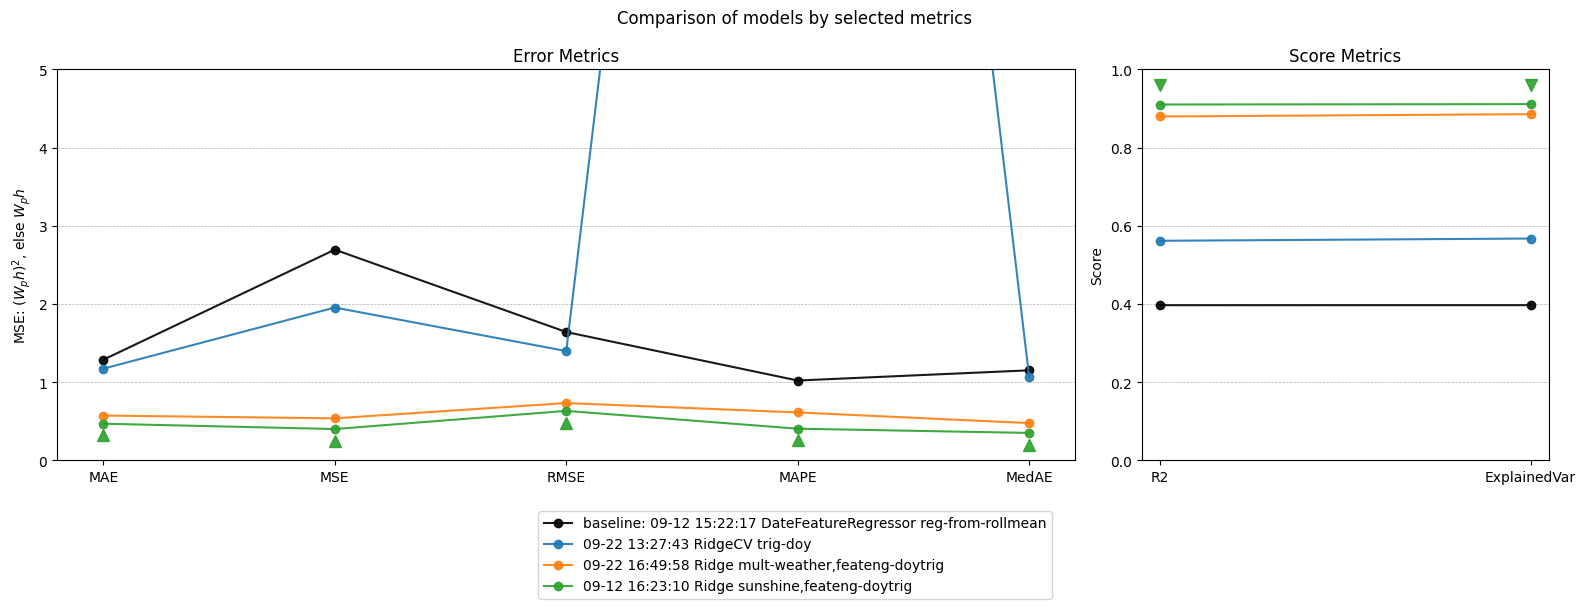

In [6]:
df_show = df.copy()
df_baseline = df_show[df_show["model_purpose"] == "baseline"]

# limit error metrics to avoid too large values in the plot
upper_y_limit_show = np.floor(
    float(df_baseline[error_metrics].max().multiply(10).max())
)

df_show[error_metrics] = df_show[error_metrics].clip(upper=upper_y_limit_show)
df_show = df_show[df_show["model_purpose"] != "baseline"]

styles = style_generator()

# Create figure and axis
fig, axes = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [len(error_metrics), len(score_metrics)]},
)
lines = {ax: [] for ax in axes}
alpha = 0.9

# Plot baseline(s)
baseline_style = style_generator(colors=["black"])
if not df_baseline.empty:
    for idx, row in df_baseline.iterrows():
        label = f"baseline: {get_row_label(row)}"
        style = next(baseline_style)

        for ax, metrics in zip(axes, [error_metrics, score_metrics]):
            line = plot_single_model(
                row,
                label if ax == axes[0] else None,  # only one label in legend
                ax,
                metrics,
                False,
                **(style | {"alpha": alpha}),
            )
            lines[ax].append((idx, line, row))

# Plot each row
for idx, row in df_show.iterrows():
    label = get_row_label(row)
    style = next(styles)
    for ax, metrics in zip(axes, [error_metrics, score_metrics]):
        line = plot_single_model(
            row,
            label if ax == axes[0] else None,  # only one label in legend
            ax,
            metrics,
            False,
            **(style | {"alpha": alpha}),
        )

        lines[ax].append((idx, line, row))

# Mark best value per column in the color of the best line
for ax, metrics, y_lim_max in zip(axes, [error_metrics, score_metrics], [None, 1]):
    for col in metrics:
        best_idx = (
            df_show[col].idxmax() if col in score_metrics else df_show[col].idxmin()
        )
        row = df_show.loc[best_idx]
        y = row[col] + (0.05 if col in score_metrics else -0.15)
        x = list(metrics).index(col)

        # Get the color of the corresponding line
        line_color = next(
            (l.get_color() for i, l, r in lines[ax] if i == best_idx), "black"
        )
        ax.plot(
            x,
            y,
            marker="v" if col in score_metrics else "^",
            color=line_color,
            markersize=8,
            alpha=alpha,
        )

# Axis and legend settings
for ax, metrics, y_lim_max in zip(
    axes,
    [error_metrics, score_metrics],
    [min(np.floor(upper_y_limit_show/5), df_show.loc[:, error_metrics].max().max()), 1],
):

    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, rotation=0, ha="center")

    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    ax.set_ylim(ymin=0, ymax=y_lim_max)
    ax.set_title("Error Metrics" if metrics == error_metrics else "Score Metrics")
    ax.set_ylabel("MSE: $(W_ph)^2$, else $W_ph$" if metrics == error_metrics else "Score")
    # ax.legend()

fig.legend(bbox_to_anchor=(0.5, -0.01), loc="upper center", ncol=min(1, len(df_show)))
fig.suptitle("Comparison of models by selected metrics")
plt.tight_layout()
plt.show()

### Plot A Chosen Models Metrics Vs The Aggregation Of All Others

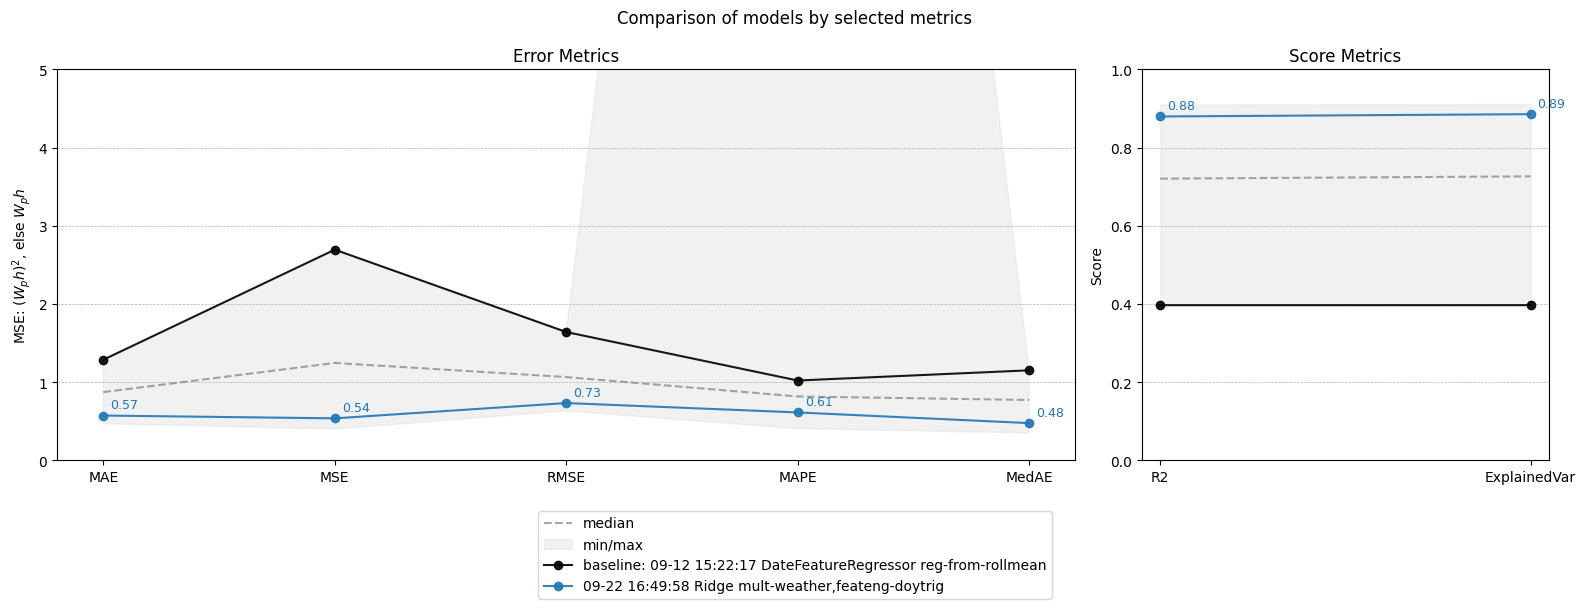

In [7]:
target_model_timestamp = None  # e.g. "2023-10-01 12:00:00"
"""The timestamp of the target model to highlight. If None or empty, the latest model is used."""

df_show = df.copy()
df_baseline = df_show[df_show["model_purpose"] == "baseline"]
# limit error metrics to avoid too large values in the plot
upper_y_limit_show = np.floor(
    float(df_baseline[error_metrics].max().multiply(10).max())
)

df_agg = (
    df[error_metrics + score_metrics]
    .clip(upper=upper_y_limit_show)  # to avoid too large values in error metrics
    .agg(["min", "max", "median"])
)

df_show[error_metrics] = df_show[error_metrics].clip(upper=upper_y_limit_show)
df_show = df_show[df_show["model_purpose"] != "baseline"]


styles = style_generator()

# Create figure and axis
fig, axes = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [len(error_metrics), len(score_metrics)]},
)
lines = {ax: [] for ax in axes}
alpha = 0.9

# Plot range and median of metrics
for ax, metrics in zip(axes, [error_metrics, score_metrics]):
    mean_vals = df_agg[metrics].loc["median"]
    (line,) = ax.plot(
        metrics,
        mean_vals,
        label="median" if ax == axes[0] else None,  # only one label in legend
        linestyle="--",
        alpha=0.7,
        color="gray",
    )
    ax.fill_between(
        metrics,
        df_agg[metrics].loc["min"],
        df_agg[metrics].loc["max"],
        alpha=0.3,
        label="min/max" if ax == axes[0] else None,  # only one label in legend
        color="lightgray",
    )

# Plot baseline(s)
baseline_style = style_generator(colors=["black"])
if not df_baseline.empty:
    for idx, row in df_baseline.iterrows():
        label = f"baseline: {get_row_label(row)}"
        style = next(baseline_style)

        for ax, metrics in zip(axes, [error_metrics, score_metrics]):
            line = plot_single_model(
                row,
                label if ax == axes[0] else None,  # only one label in legend
                ax,
                metrics,
                False,
                **(style | {"alpha": alpha}),
            )
            lines[ax].append((idx, line, row))

if target_model_timestamp is None or target_model_timestamp == "":
    target_model_timestamp = df_show.index.max()
elif target_model_timestamp not in df_show.index:
    raise ValueError(f"timestamp '{target_model_timestamp}' not found in df.index")


# Plot single model
for idx, row in df_show.loc[df_show.index == target_model_timestamp, :].iterrows():
    label = get_row_label(row)
    style = next(styles)
    for ax, metrics in zip(axes, [error_metrics, score_metrics]):
        line = plot_single_model(
            row,
            label if ax == axes[0] else None,  # only one label in legend
            ax,
            metrics,
            True,
            **(style | {"alpha": alpha}),
        )

# Axis and legend settings
for ax, metrics, y_lim_max in zip(
    axes,
    [error_metrics, score_metrics],
    [min(np.floor(upper_y_limit_show/5), df_show.loc[:, error_metrics].max().max()), 1],
):

    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, rotation=0, ha="center")

    ax.grid(axis="y", linestyle="--", linewidth=0.5)
    ax.set_ylim(ymin=0, ymax=y_lim_max)
    ax.set_title("Error Metrics" if metrics == error_metrics else "Score Metrics")
    ax.set_ylabel("MSE: $(W_ph)^2$, else $W_ph$" if metrics == error_metrics else "Score")

fig.legend(bbox_to_anchor=(0.5, -0.01), loc="upper center", ncol=min(1, len(df_show)))
fig.suptitle("Comparison of models by selected metrics")
plt.tight_layout()
plt.show()